In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
K = keras.backend

In [3]:
# Common imports
import math
import os

import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import pickle

import seaborn as sns; sns.set()

In [4]:
import utils

In [5]:
root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir(postfix=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    if postfix is not None:
        run_id = run_id + '_' + postfix
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_04_18-21_21_42'

In [6]:
# to make this notebook's output stable across runs
RSEED = 42

np.random.seed(RSEED)
tf.random.set_seed(RSEED)

## Data

In [7]:
# Importing the dataset
df, df_avg = utils.load_sensors_data()
df_avg.head()

,people,co2,hum_avg,temp_avg,light_avg
120,0.0,394.0,46.16000,30.10900,0.0
121,0.0,394.0,46.20775,30.12425,0.0
122,0.0,394.0,46.18525,30.13775,0.0
123,0.0,394.0,46.18750,30.13775,0.0
124,0.0,395.0,46.19325,30.13750,0.0


In [8]:
# Assigning the input and output values
X_root = df.iloc[:, 2:]
y_root = df.iloc[:, 1]
X_avg = df_avg.iloc[:, 1:]

X_avg.head()

,co2,hum_avg,temp_avg,light_avg
120,394.0,46.16000,30.10900,0.0
121,394.0,46.20775,30.12425,0.0
122,394.0,46.18525,30.13775,0.0
123,394.0,46.18750,30.13775,0.0
124,395.0,46.19325,30.13750,0.0


In [9]:
from sklearn.model_selection import train_test_split


X_avg_train_val, X_avg_test, y_avg_train_val, y_avg_test = train_test_split(
    X_avg, y_root, test_size=0.3, random_state=RSEED)
X_avg_train, X_avg_val, y_avg_train, y_avg_val = train_test_split(
    X_avg_train_val, y_avg_train_val, test_size=0.2, random_state=RSEED)

X_root_train_val, X_root_test, y_root_train_val, y_root_test = train_test_split(
    X_root, y_root, test_size=0.3, random_state=RSEED)
X_root_train, X_root_val, y_root_train, y_root_val = train_test_split(
    X_root_train_val, y_root_train_val, test_size=0.2, random_state=RSEED)

In [10]:
std_scaler_X_avg = StandardScaler()
std_scaler_X_avg.fit(X_avg_train_val)

X_avg_train_val_scaled = std_scaler_X_avg.transform(X_avg_train_val)
X_avg_train_scaled = std_scaler_X_avg.transform(X_avg_train)
X_avg_val_scaled = std_scaler_X_avg.transform(X_avg_val)
X_avg_test_scaled = std_scaler_X_avg.transform(X_avg_test)

std_scaler_X = StandardScaler()
std_scaler_X.fit(X_root_train_val)

X_root_train_val_scaled = std_scaler_X.transform(X_root_train_val)
X_root_train_scaled = std_scaler_X.transform(X_root_train)
X_root_val_scaled = std_scaler_X.transform(X_root_val)
X_root_test_scaled = std_scaler_X.transform(X_root_test)

X_avg_train_val_scaled

array([[ 0.09991889,  0.61703517,  1.02739192, -1.57390866],
       [ 0.86562882,  0.56737213, -0.25703667,  0.42482764],
       [-0.23894849,  0.48846928, -0.83632442,  0.80081746],
       ...,
       [ 0.81675371,  0.62588895, -0.7218299 ,  0.88286009],
       [ 1.13932939, -1.13318699, -0.41196775,  0.77802369],
       [-1.26206729,  1.8633356 , -0.14890296, -1.57390866]])

## Model

In [23]:
n_neurons = 100

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[
              "mae"])
# model.compile(loss="mean_squared_error", optimizer='nadam', metrics=[
#               "mae"])

# early_stopping_cb = keras.callbacks.EarlyStopping(
#     patience=40, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "people_model_nadam.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir('nadam'))

n_epochs = 1500
history = model.fit(X_avg_train_val_scaled, y_avg_train_val, epochs=n_epochs,
                    validation_data=(X_avg_val_scaled, y_avg_val), callbacks=[checkpoint_cb, tensorboard_cb])


Train on 6127 samples, validate on 1226 samples
Epoch 1/1500
6127/6127 [==============================] - 1s 218us/sample - loss: 4.1493 - mae: 1.3919 - val_loss: 5.0587 - val_mae: 1.7040
Epoch 2/1500
6127/6127 [==============================] - 0s 71us/sample - loss: 3.0978 - mae: 1.1827 - val_loss: 3.6870 - val_mae: 1.2605
Epoch 3/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 2.9111 - mae: 1.1413 - val_loss: 3.6547 - val_mae: 1.2567
Epoch 4/1500
6127/6127 [==============================] - 0s 66us/sample - loss: 2.5926 - mae: 1.0609 - val_loss: 2.7320 - val_mae: 1.0612
Epoch 5/1500
6127/6127 [==============================] - 0s 67us/sample - loss: 2.5673 - mae: 1.0407 - val_loss: 2.5695 - val_mae: 0.9925
Epoch 6/1500
6127/6127 [==============================] - 0s 66us/sample - loss: 2.4189 - mae: 1.0189 - val_loss: 2.3242 - val_mae: 1.0089
Epoch 7/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 2.2771 - mae: 0.9843 - val_loss: 2.5

6127/6127 [==============================] - 0s 59us/sample - loss: 0.7578 - mae: 0.5355 - val_loss: 0.8992 - val_mae: 0.5604
Epoch 60/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.8340 - mae: 0.5425 - val_loss: 1.0168 - val_mae: 0.5874
Epoch 61/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.9047 - mae: 0.5688 - val_loss: 0.6672 - val_mae: 0.5094
Epoch 62/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.9405 - mae: 0.5694 - val_loss: 1.0859 - val_mae: 0.6517
Epoch 63/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.9183 - mae: 0.5813 - val_loss: 0.8230 - val_mae: 0.5468
Epoch 64/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.7348 - mae: 0.5264 - val_loss: 0.9939 - val_mae: 0.5529
Epoch 65/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.8088 - mae: 0.5356 - val_loss: 0.7331 - val_mae: 0.5178
Epoch 66/1500
6127/6127 [=========

6127/6127 [==============================] - 0s 56us/sample - loss: 0.5297 - mae: 0.4313 - val_loss: 0.7298 - val_mae: 0.4541
Epoch 118/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.6108 - mae: 0.4527 - val_loss: 0.4634 - val_mae: 0.4136
Epoch 119/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.6466 - mae: 0.4689 - val_loss: 0.5596 - val_mae: 0.3991
Epoch 120/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.5952 - mae: 0.4430 - val_loss: 0.6468 - val_mae: 0.4515
Epoch 121/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.6204 - mae: 0.4623 - val_loss: 0.4536 - val_mae: 0.4107
Epoch 122/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.6214 - mae: 0.4599 - val_loss: 0.4211 - val_mae: 0.3789
Epoch 123/1500
6127/6127 [==============================] - 0s 56us/sample - loss: 0.5803 - mae: 0.4455 - val_loss: 0.5349 - val_mae: 0.4237
Epoch 124/1500
6127/6127 [==

6127/6127 [==============================] - 0s 68us/sample - loss: 0.4925 - mae: 0.3957 - val_loss: 0.4186 - val_mae: 0.3812
Epoch 176/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.6838 - mae: 0.4668 - val_loss: 0.4904 - val_mae: 0.3940
Epoch 177/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.6044 - mae: 0.4451 - val_loss: 0.4227 - val_mae: 0.3910
Epoch 178/1500
6127/6127 [==============================] - 0s 69us/sample - loss: 0.4816 - mae: 0.3976 - val_loss: 0.5016 - val_mae: 0.4152
Epoch 179/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.4913 - mae: 0.4009 - val_loss: 0.4450 - val_mae: 0.3776
Epoch 180/1500
6127/6127 [==============================] - 0s 69us/sample - loss: 0.5612 - mae: 0.4250 - val_loss: 0.3864 - val_mae: 0.3587
Epoch 181/1500
6127/6127 [==============================] - 0s 69us/sample - loss: 0.4561 - mae: 0.3892 - val_loss: 0.3745 - val_mae: 0.3329
Epoch 182/1500
6127/6127 [==

6127/6127 [==============================] - 0s 59us/sample - loss: 0.3727 - mae: 0.3488 - val_loss: 0.2963 - val_mae: 0.3087
Epoch 234/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3463 - mae: 0.3279 - val_loss: 0.3162 - val_mae: 0.3178
Epoch 235/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.3951 - mae: 0.3498 - val_loss: 0.3875 - val_mae: 0.3443
Epoch 236/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.4054 - mae: 0.3657 - val_loss: 0.3486 - val_mae: 0.3524
Epoch 237/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.5149 - mae: 0.3910 - val_loss: 0.4035 - val_mae: 0.3367
Epoch 238/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.4228 - mae: 0.3617 - val_loss: 0.3090 - val_mae: 0.3336
Epoch 239/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3325 - mae: 0.3335 - val_loss: 0.4059 - val_mae: 0.3357
Epoch 240/1500
6127/6127 [==

6127/6127 [==============================] - 0s 62us/sample - loss: 0.4045 - mae: 0.3461 - val_loss: 0.3810 - val_mae: 0.3124
Epoch 292/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.4250 - mae: 0.3649 - val_loss: 1.5997 - val_mae: 0.4011
Epoch 293/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.5015 - mae: 0.4063 - val_loss: 0.4380 - val_mae: 0.3742
Epoch 294/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.3733 - mae: 0.3570 - val_loss: 0.2693 - val_mae: 0.3052
Epoch 295/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.4007 - mae: 0.3552 - val_loss: 0.3998 - val_mae: 0.3568
Epoch 296/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.3661 - mae: 0.3534 - val_loss: 0.2465 - val_mae: 0.2872
Epoch 297/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.4354 - mae: 0.3583 - val_loss: 0.3290 - val_mae: 0.3692
Epoch 298/1500
6127/6127 [==

6127/6127 [==============================] - 0s 59us/sample - loss: 0.3127 - mae: 0.3186 - val_loss: 0.3020 - val_mae: 0.3046
Epoch 350/1500
6127/6127 [==============================] - 0s 67us/sample - loss: 0.7983 - mae: 0.4808 - val_loss: 0.9317 - val_mae: 0.5736
Epoch 351/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.8274 - mae: 0.5354 - val_loss: 0.6842 - val_mae: 0.4659
Epoch 352/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.6060 - mae: 0.4430 - val_loss: 0.4502 - val_mae: 0.3639
Epoch 353/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.5227 - mae: 0.4032 - val_loss: 0.3634 - val_mae: 0.3322
Epoch 354/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.4304 - mae: 0.3698 - val_loss: 0.2916 - val_mae: 0.3029
Epoch 355/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3852 - mae: 0.3438 - val_loss: 0.3548 - val_mae: 0.3289
Epoch 356/1500
6127/6127 [==

6127/6127 [==============================] - 0s 61us/sample - loss: 0.3544 - mae: 0.3260 - val_loss: 0.2617 - val_mae: 0.2876
Epoch 408/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.2576 - mae: 0.2930 - val_loss: 0.2051 - val_mae: 0.2606
Epoch 409/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.2490 - mae: 0.2887 - val_loss: 0.1990 - val_mae: 0.2669
Epoch 410/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.5223 - mae: 0.3826 - val_loss: 0.2997 - val_mae: 0.2984
Epoch 411/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3141 - mae: 0.3245 - val_loss: 0.2828 - val_mae: 0.2925
Epoch 412/1500
6127/6127 [==============================] - 0s 63us/sample - loss: 0.3094 - mae: 0.3145 - val_loss: 0.3067 - val_mae: 0.2954
Epoch 413/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.3232 - mae: 0.3173 - val_loss: 0.2399 - val_mae: 0.2867
Epoch 414/1500
6127/6127 [==

6127/6127 [==============================] - 0s 61us/sample - loss: 0.3754 - mae: 0.3441 - val_loss: 0.3144 - val_mae: 0.2921
Epoch 466/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2666 - mae: 0.3013 - val_loss: 0.2222 - val_mae: 0.2711
Epoch 467/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2990 - mae: 0.3065 - val_loss: 0.2663 - val_mae: 0.3013
Epoch 468/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.2959 - mae: 0.3070 - val_loss: 0.2411 - val_mae: 0.2691
Epoch 469/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.2601 - mae: 0.2889 - val_loss: 0.2252 - val_mae: 0.2639
Epoch 470/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.2250 - mae: 0.2747 - val_loss: 0.3171 - val_mae: 0.3090
Epoch 471/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.3797 - mae: 0.3380 - val_loss: 0.4306 - val_mae: 0.3711
Epoch 472/1500
6127/6127 [==

6127/6127 [==============================] - 0s 57us/sample - loss: 0.2975 - mae: 0.3112 - val_loss: 0.2923 - val_mae: 0.2808
Epoch 524/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.4518 - mae: 0.3717 - val_loss: 0.3523 - val_mae: 0.3097
Epoch 525/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.2971 - mae: 0.3242 - val_loss: 0.2995 - val_mae: 0.3239
Epoch 526/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3066 - mae: 0.3195 - val_loss: 0.3006 - val_mae: 0.3154
Epoch 527/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3048 - mae: 0.3204 - val_loss: 0.2940 - val_mae: 0.2858
Epoch 528/1500
6127/6127 [==============================] - 0s 66us/sample - loss: 0.2801 - mae: 0.3184 - val_loss: 0.3563 - val_mae: 0.3141
Epoch 529/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.5122 - mae: 0.3792 - val_loss: 0.4275 - val_mae: 0.3750
Epoch 530/1500
6127/6127 [==

6127/6127 [==============================] - 0s 62us/sample - loss: 0.2059 - mae: 0.2595 - val_loss: 0.2646 - val_mae: 0.2861
Epoch 582/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.2302 - mae: 0.2692 - val_loss: 0.3509 - val_mae: 0.3038
Epoch 583/1500
6127/6127 [==============================] - 0s 63us/sample - loss: 0.3439 - mae: 0.3120 - val_loss: 0.2246 - val_mae: 0.2877
Epoch 584/1500
6127/6127 [==============================] - 0s 67us/sample - loss: 0.2237 - mae: 0.2687 - val_loss: 0.1575 - val_mae: 0.2337
Epoch 585/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2091 - mae: 0.2650 - val_loss: 0.1820 - val_mae: 0.2513
Epoch 586/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.2011 - mae: 0.2548 - val_loss: 0.1653 - val_mae: 0.2397
Epoch 587/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3134 - mae: 0.2956 - val_loss: 0.3306 - val_mae: 0.3075
Epoch 588/1500
6127/6127 [==

6127/6127 [==============================] - 0s 60us/sample - loss: 0.3160 - mae: 0.3165 - val_loss: 0.2627 - val_mae: 0.2731
Epoch 640/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3211 - mae: 0.3040 - val_loss: 0.3632 - val_mae: 0.3457
Epoch 641/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3721 - mae: 0.3264 - val_loss: 0.2167 - val_mae: 0.2760
Epoch 642/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3324 - mae: 0.3015 - val_loss: 0.1811 - val_mae: 0.2559
Epoch 643/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3132 - mae: 0.2915 - val_loss: 0.2133 - val_mae: 0.2524
Epoch 644/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3482 - mae: 0.3052 - val_loss: 0.2373 - val_mae: 0.2978
Epoch 645/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.2726 - mae: 0.2906 - val_loss: 0.2204 - val_mae: 0.2641
Epoch 646/1500
6127/6127 [==

6127/6127 [==============================] - 0s 76us/sample - loss: 0.2777 - mae: 0.2992 - val_loss: 0.2376 - val_mae: 0.2799
Epoch 698/1500
6127/6127 [==============================] - 0s 78us/sample - loss: 0.3595 - mae: 0.3220 - val_loss: 0.1818 - val_mae: 0.2616
Epoch 699/1500
6127/6127 [==============================] - 0s 81us/sample - loss: 0.3604 - mae: 0.3035 - val_loss: 0.8636 - val_mae: 0.4522
Epoch 700/1500
6127/6127 [==============================] - 0s 76us/sample - loss: 0.4823 - mae: 0.3762 - val_loss: 0.3112 - val_mae: 0.3350
Epoch 701/1500
6127/6127 [==============================] - 0s 75us/sample - loss: 0.4742 - mae: 0.3664 - val_loss: 0.3965 - val_mae: 0.3424
Epoch 702/1500
6127/6127 [==============================] - 0s 72us/sample - loss: 0.4053 - mae: 0.3520 - val_loss: 0.2389 - val_mae: 0.2840
Epoch 703/1500
6127/6127 [==============================] - 0s 72us/sample - loss: 0.3018 - mae: 0.3013 - val_loss: 0.2521 - val_mae: 0.3097
Epoch 704/1500
6127/6127 [==

6127/6127 [==============================] - 0s 56us/sample - loss: 0.2806 - mae: 0.2952 - val_loss: 0.1792 - val_mae: 0.2412
Epoch 756/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.1968 - mae: 0.2554 - val_loss: 0.1577 - val_mae: 0.2379
Epoch 757/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.2491 - mae: 0.2659 - val_loss: 0.3664 - val_mae: 0.2977
Epoch 758/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3955 - mae: 0.3185 - val_loss: 0.5702 - val_mae: 0.3635
Epoch 759/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.6669 - mae: 0.4702 - val_loss: 0.3098 - val_mae: 0.3284
Epoch 760/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.3668 - mae: 0.3502 - val_loss: 0.3232 - val_mae: 0.3307
Epoch 761/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.2617 - mae: 0.2976 - val_loss: 0.2013 - val_mae: 0.2806
Epoch 762/1500
6127/6127 [==

6127/6127 [==============================] - 0s 54us/sample - loss: 0.2539 - mae: 0.2789 - val_loss: 0.2240 - val_mae: 0.2623
Epoch 814/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.2712 - mae: 0.2822 - val_loss: 0.4708 - val_mae: 0.3508
Epoch 815/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.3418 - mae: 0.3195 - val_loss: 0.2185 - val_mae: 0.2782
Epoch 816/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.2177 - mae: 0.2635 - val_loss: 0.1675 - val_mae: 0.2349
Epoch 817/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.1897 - mae: 0.2477 - val_loss: 0.1876 - val_mae: 0.2335
Epoch 818/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.2065 - mae: 0.2627 - val_loss: 0.1896 - val_mae: 0.2532
Epoch 819/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.2314 - mae: 0.2651 - val_loss: 0.2208 - val_mae: 0.2905
Epoch 820/1500
6127/6127 [==

6127/6127 [==============================] - 0s 54us/sample - loss: 0.1514 - mae: 0.2253 - val_loss: 0.1335 - val_mae: 0.2136
Epoch 872/1500
6127/6127 [==============================] - 0s 65us/sample - loss: 0.6244 - mae: 0.3591 - val_loss: 0.5167 - val_mae: 0.4591
Epoch 873/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.6782 - mae: 0.4959 - val_loss: 0.3158 - val_mae: 0.3600
Epoch 874/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.3490 - mae: 0.3628 - val_loss: 0.2534 - val_mae: 0.3303
Epoch 875/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2402 - mae: 0.3080 - val_loss: 0.1934 - val_mae: 0.2721
Epoch 876/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2247 - mae: 0.2859 - val_loss: 0.1767 - val_mae: 0.2598
Epoch 877/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2301 - mae: 0.2921 - val_loss: 0.1810 - val_mae: 0.2587
Epoch 878/1500
6127/6127 [==

6127/6127 [==============================] - 0s 62us/sample - loss: 0.6596 - mae: 0.5002 - val_loss: 0.4888 - val_mae: 0.4372
Epoch 930/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.5767 - mae: 0.4645 - val_loss: 0.4361 - val_mae: 0.4061
Epoch 931/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.5254 - mae: 0.4440 - val_loss: 0.4028 - val_mae: 0.3968
Epoch 932/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.4755 - mae: 0.4239 - val_loss: 0.3815 - val_mae: 0.3746
Epoch 933/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.4419 - mae: 0.4036 - val_loss: 0.3392 - val_mae: 0.3584
Epoch 934/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.4273 - mae: 0.3978 - val_loss: 0.3188 - val_mae: 0.3492
Epoch 935/1500
6127/6127 [==============================] - 0s 64us/sample - loss: 0.4052 - mae: 0.3873 - val_loss: 0.2932 - val_mae: 0.3339
Epoch 936/1500
6127/6127 [==

6127/6127 [==============================] - 0s 53us/sample - loss: 0.2145 - mae: 0.2791 - val_loss: 0.1696 - val_mae: 0.2476
Epoch 988/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2124 - mae: 0.2701 - val_loss: 0.2477 - val_mae: 0.2950
Epoch 989/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2217 - mae: 0.2785 - val_loss: 0.1815 - val_mae: 0.2523
Epoch 990/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2310 - mae: 0.2884 - val_loss: 0.3192 - val_mae: 0.3037
Epoch 991/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2722 - mae: 0.3051 - val_loss: 0.1780 - val_mae: 0.2628
Epoch 992/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2262 - mae: 0.2861 - val_loss: 0.2480 - val_mae: 0.2647
Epoch 993/1500
6127/6127 [==============================] - 0s 52us/sample - loss: 0.2006 - mae: 0.2729 - val_loss: 0.1680 - val_mae: 0.2457
Epoch 994/1500
6127/6127 [==

Epoch 1045/1500
6127/6127 [==============================] - 0s 70us/sample - loss: 0.3593 - mae: 0.3465 - val_loss: 0.2220 - val_mae: 0.2746
Epoch 1046/1500
6127/6127 [==============================] - 0s 74us/sample - loss: 0.3277 - mae: 0.3251 - val_loss: 0.3699 - val_mae: 0.3172
Epoch 1047/1500
6127/6127 [==============================] - 0s 75us/sample - loss: 0.3859 - mae: 0.3413 - val_loss: 0.5298 - val_mae: 0.3843
Epoch 1048/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.3223 - mae: 0.3257 - val_loss: 0.2513 - val_mae: 0.3062
Epoch 1049/1500
6127/6127 [==============================] - 0s 63us/sample - loss: 0.2439 - mae: 0.2944 - val_loss: 0.3090 - val_mae: 0.3272
Epoch 1050/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.2603 - mae: 0.2990 - val_loss: 0.2117 - val_mae: 0.2614
Epoch 1051/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.2875 - mae: 0.3017 - val_loss: 0.3183 - val_mae: 0.3344
Epoch 

Epoch 1103/1500
6127/6127 [==============================] - 0s 58us/sample - loss: 0.2655 - mae: 0.2995 - val_loss: 0.2120 - val_mae: 0.2530
Epoch 1104/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2357 - mae: 0.2816 - val_loss: 0.1702 - val_mae: 0.2435
Epoch 1105/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.2131 - mae: 0.2684 - val_loss: 0.1966 - val_mae: 0.3009
Epoch 1106/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.2430 - mae: 0.2779 - val_loss: 0.2593 - val_mae: 0.2542
Epoch 1107/1500
6127/6127 [==============================] - 0s 66us/sample - loss: 0.3796 - mae: 0.3369 - val_loss: 0.2605 - val_mae: 0.3027
Epoch 1108/1500
6127/6127 [==============================] - 0s 69us/sample - loss: 0.2655 - mae: 0.2956 - val_loss: 0.1833 - val_mae: 0.2575
Epoch 1109/1500
6127/6127 [==============================] - 0s 67us/sample - loss: 0.2704 - mae: 0.2888 - val_loss: 0.1900 - val_mae: 0.2747
Epoch 

Epoch 1161/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2474 - mae: 0.2678 - val_loss: 0.1432 - val_mae: 0.2356
Epoch 1162/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.1789 - mae: 0.2494 - val_loss: 0.1525 - val_mae: 0.2648
Epoch 1163/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.1685 - mae: 0.2420 - val_loss: 0.1683 - val_mae: 0.2462
Epoch 1164/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.1676 - mae: 0.2346 - val_loss: 0.1360 - val_mae: 0.2330
Epoch 1165/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.1418 - mae: 0.2168 - val_loss: 0.1314 - val_mae: 0.2381
Epoch 1166/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.2123 - mae: 0.2523 - val_loss: 0.1899 - val_mae: 0.2359
Epoch 1167/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 1.2334 - mae: 0.3974 - val_loss: 1.5037 - val_mae: 0.7152
Epoch 

6127/6127 [==============================] - 0s 63us/sample - loss: 0.3789 - mae: 0.3581 - val_loss: 0.3076 - val_mae: 0.3188
Epoch 1219/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3801 - mae: 0.3580 - val_loss: 0.3149 - val_mae: 0.3374
Epoch 1220/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3570 - mae: 0.3507 - val_loss: 0.2910 - val_mae: 0.3180
Epoch 1221/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.3579 - mae: 0.3497 - val_loss: 0.3113 - val_mae: 0.3379
Epoch 1222/1500
6127/6127 [==============================] - 0s 65us/sample - loss: 0.3522 - mae: 0.3497 - val_loss: 0.3044 - val_mae: 0.3353
Epoch 1223/1500
6127/6127 [==============================] - 0s 79us/sample - loss: 0.3961 - mae: 0.3582 - val_loss: 0.3016 - val_mae: 0.3221
Epoch 1224/1500
6127/6127 [==============================] - 0s 78us/sample - loss: 0.3657 - mae: 0.3518 - val_loss: 0.2681 - val_mae: 0.2988
Epoch 1225/1500
6127/6

Epoch 1276/1500
6127/6127 [==============================] - 0s 56us/sample - loss: 0.3502 - mae: 0.3601 - val_loss: 0.3237 - val_mae: 0.3307
Epoch 1277/1500
6127/6127 [==============================] - 0s 56us/sample - loss: 0.3815 - mae: 0.3708 - val_loss: 0.3253 - val_mae: 0.3390
Epoch 1278/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.3422 - mae: 0.3560 - val_loss: 0.3469 - val_mae: 0.3684
Epoch 1279/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.4628 - mae: 0.4171 - val_loss: 0.3666 - val_mae: 0.3804
Epoch 1280/1500
6127/6127 [==============================] - 0s 56us/sample - loss: 0.3790 - mae: 0.3707 - val_loss: 0.2827 - val_mae: 0.3223
Epoch 1281/1500
6127/6127 [==============================] - 0s 57us/sample - loss: 0.4285 - mae: 0.3695 - val_loss: 0.3867 - val_mae: 0.3759
Epoch 1282/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3733 - mae: 0.3633 - val_loss: 0.2677 - val_mae: 0.3090
Epoch 

Epoch 1334/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2652 - mae: 0.3032 - val_loss: 0.2148 - val_mae: 0.2601
Epoch 1335/1500
6127/6127 [==============================] - 0s 60us/sample - loss: 0.2357 - mae: 0.2925 - val_loss: 0.2442 - val_mae: 0.2794
Epoch 1336/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3183 - mae: 0.3207 - val_loss: 0.2338 - val_mae: 0.2951
Epoch 1337/1500
6127/6127 [==============================] - 0s 63us/sample - loss: 0.2771 - mae: 0.3050 - val_loss: 0.2195 - val_mae: 0.2783
Epoch 1338/1500
6127/6127 [==============================] - 0s 63us/sample - loss: 0.4789 - mae: 0.3749 - val_loss: 0.2393 - val_mae: 0.2912
Epoch 1339/1500
6127/6127 [==============================] - 0s 61us/sample - loss: 0.3153 - mae: 0.3322 - val_loss: 0.1940 - val_mae: 0.2699
Epoch 1340/1500
6127/6127 [==============================] - 0s 62us/sample - loss: 0.2552 - mae: 0.3051 - val_loss: 0.1680 - val_mae: 0.2396
Epoch 

Epoch 1392/1500
6127/6127 [==============================] - 0s 54us/sample - loss: 0.2938 - mae: 0.3133 - val_loss: 0.2229 - val_mae: 0.2801
Epoch 1393/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.2592 - mae: 0.2981 - val_loss: 0.2521 - val_mae: 0.2799
Epoch 1394/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.2671 - mae: 0.3015 - val_loss: 0.2524 - val_mae: 0.3183
Epoch 1395/1500
6127/6127 [==============================] - 0s 53us/sample - loss: 0.2615 - mae: 0.3013 - val_loss: 0.2250 - val_mae: 0.2893
Epoch 1396/1500
6127/6127 [==============================] - 0s 55us/sample - loss: 0.2928 - mae: 0.3107 - val_loss: 0.2042 - val_mae: 0.2611
Epoch 1397/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.2681 - mae: 0.3008 - val_loss: 0.2186 - val_mae: 0.2699
Epoch 1398/1500
6127/6127 [==============================] - 0s 59us/sample - loss: 0.2613 - mae: 0.2917 - val_loss: 0.2543 - val_mae: 0.2681
Epoch 

6127/6127 [==============================] - 0s 67us/sample - loss: 0.3427 - mae: 0.3448 - val_loss: 0.3158 - val_mae: 0.3387
Epoch 1450/1500
6127/6127 [==============================] - 0s 65us/sample - loss: 53.0963 - mae: 0.4330 - val_loss: 2.0539 - val_mae: 1.2992
Epoch 1451/1500
6127/6127 [==============================] - 0s 65us/sample - loss: 1594.6268 - mae: 2.1347 - val_loss: 1.2613 - val_mae: 0.7922
Epoch 1452/1500
6127/6127 [==============================] - 0s 67us/sample - loss: 1.0037 - mae: 0.6812 - val_loss: 0.7341 - val_mae: 0.5853
Epoch 1453/1500
6127/6127 [==============================] - 0s 68us/sample - loss: 0.8354 - mae: 0.6146 - val_loss: 0.6762 - val_mae: 0.5554
Epoch 1454/1500
6127/6127 [==============================] - 0s 71us/sample - loss: 0.7072 - mae: 0.5668 - val_loss: 0.5842 - val_mae: 0.5162
Epoch 1455/1500
6127/6127 [==============================] - 0s 65us/sample - loss: 0.6335 - mae: 0.5343 - val_loss: 0.5499 - val_mae: 0.4963
Epoch 1456/1500
61

In [24]:
with open('people_model_nadam_history.pkl', 'wb') as pickle_file:
    pickle_file.write(pickle.dumps(history.history))

In [ ]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["mae"])

batch_size = 128
rates, losses = find_learning_rate(model, X_avg_train_val_scaled, y_avg_train_val, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
rates[np.argmin(losses)]

In [22]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(
                0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.001), metrics=[
              "mae"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=40, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "people_model_1cycle.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir('1cycle'))


batch_size = 128
# batch_size = 32
n_epochs = 500
onecycle = OneCycleScheduler(len(X_avg_train_val_scaled) //
                             batch_size * n_epochs, max_rate=0.05, start_rate=0.005)

history = model.fit(X_avg_train_val_scaled, y_avg_train_val, epochs=n_epochs,
                    validation_data=(X_avg_val_scaled, y_avg_val), callbacks=[onecycle, checkpoint_cb, tensorboard_cb])

Train on 6127 samples, validate on 1226 samples
Epoch 1/500
6127/6127 [==============================] - 0s 79us/sample - loss: 4.7480 - mae: 1.5498 - val_loss: 4.9825 - val_mae: 1.7464
Epoch 2/500
6127/6127 [==============================] - 0s 41us/sample - loss: 3.4967 - mae: 1.3035 - val_loss: 3.6836 - val_mae: 1.3074
Epoch 3/500
6127/6127 [==============================] - 0s 42us/sample - loss: 3.3390 - mae: 1.2780 - val_loss: 3.7404 - val_mae: 1.3908
Epoch 4/500
6127/6127 [==============================] - 0s 41us/sample - loss: 3.1960 - mae: 1.2503 - val_loss: 3.0830 - val_mae: 1.1882
Epoch 5/500
6127/6127 [==============================] - 0s 41us/sample - loss: 3.1883 - mae: 1.2458 - val_loss: 3.0221 - val_mae: 1.1772
Epoch 6/500
6127/6127 [==============================] - 0s 41us/sample - loss: 3.1455 - mae: 1.2358 - val_loss: 3.1889 - val_mae: 1.2342
Epoch 7/500
6127/6127 [==============================] - 0s 40us/sample - loss: 3.0480 - mae: 1.2199 - val_loss: 3.1330 - va

6127/6127 [==============================] - 0s 40us/sample - loss: 2.4006 - mae: 1.0611 - val_loss: 3.6726 - val_mae: 1.4551
Epoch 60/500
6127/6127 [==============================] - 0s 41us/sample - loss: 2.3809 - mae: 1.0526 - val_loss: 3.8331 - val_mae: 1.2937
Epoch 61/500
6127/6127 [==============================] - 0s 41us/sample - loss: 2.3752 - mae: 1.0424 - val_loss: 2.0666 - val_mae: 0.9734
Epoch 62/500
6127/6127 [==============================] - 0s 40us/sample - loss: 2.3361 - mae: 1.0488 - val_loss: 2.8132 - val_mae: 1.1695
Epoch 63/500
6127/6127 [==============================] - 0s 40us/sample - loss: 2.3337 - mae: 1.0509 - val_loss: 2.2193 - val_mae: 1.0702
Epoch 64/500
6127/6127 [==============================] - 0s 41us/sample - loss: 2.3150 - mae: 1.0314 - val_loss: 3.0711 - val_mae: 1.2986
Epoch 65/500
6127/6127 [==============================] - 0s 41us/sample - loss: 2.3315 - mae: 1.0509 - val_loss: 2.1248 - val_mae: 1.0157
Epoch 66/500
6127/6127 [================

Epoch 118/500
6127/6127 [==============================] - 0s 41us/sample - loss: 1.9268 - mae: 0.9304 - val_loss: 2.2301 - val_mae: 0.9682
Epoch 119/500
6127/6127 [==============================] - 0s 41us/sample - loss: 1.9707 - mae: 0.9436 - val_loss: 2.1492 - val_mae: 0.9192
Epoch 120/500
6127/6127 [==============================] - 0s 41us/sample - loss: 2.0952 - mae: 0.9756 - val_loss: 1.8890 - val_mae: 0.8954
Epoch 121/500
6127/6127 [==============================] - 0s 41us/sample - loss: 1.8809 - mae: 0.9287 - val_loss: 1.8624 - val_mae: 0.9011
Epoch 122/500
6127/6127 [==============================] - 0s 41us/sample - loss: 1.8549 - mae: 0.9103 - val_loss: 2.9456 - val_mae: 1.2932
Epoch 123/500
6127/6127 [==============================] - 0s 40us/sample - loss: 1.8868 - mae: 0.9231 - val_loss: 1.9876 - val_mae: 0.9853
Epoch 124/500
6127/6127 [==============================] - 0s 40us/sample - loss: 1.9992 - mae: 0.9488 - val_loss: 2.0238 - val_mae: 0.9452
Epoch 125/500
6127/6

KeyboardInterrupt: 

2627/2627 [==============================] - 0s 47us/sample - loss: 0.6846 - mae: 0.4105
Saving figure ann_learning_curve


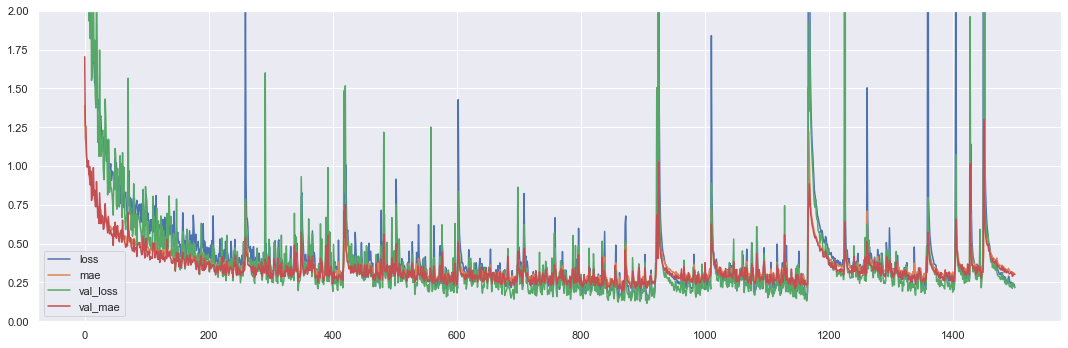

In [12]:
model = keras.models.load_model("people_model_nadam.h5")
with open('people_model_nadam_history.pkl', 'rb') as pickle_file:
    history = pickle.load(pickle_file)

mse_test = model.evaluate(X_avg_test_scaled, y_avg_test)
pd.DataFrame(history).plot(figsize=(15, 5))
plt.gca().set_ylim(0, 2)
# plt.grid(True)
utils.save_fig('ann_learning_curve')
plt.show()

In [15]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 100)              

Training RMSE : 0.3648914405791407
Training MAE : 0.22131486411426982
Training Explained Variance : 0.9891018532366208
Testing RMSE : 0.8274125235617775
Testing MAE : 0.4105147292371662
Testing Explained Variance : 0.9458014790098795
Saving figure ANN_pred_actual_instance_train


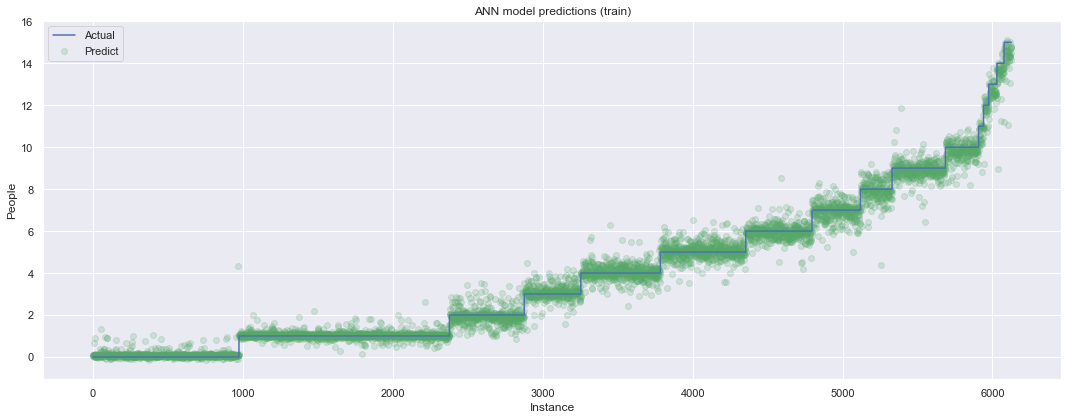

Saving figure ANN_pred_actual_instance_test


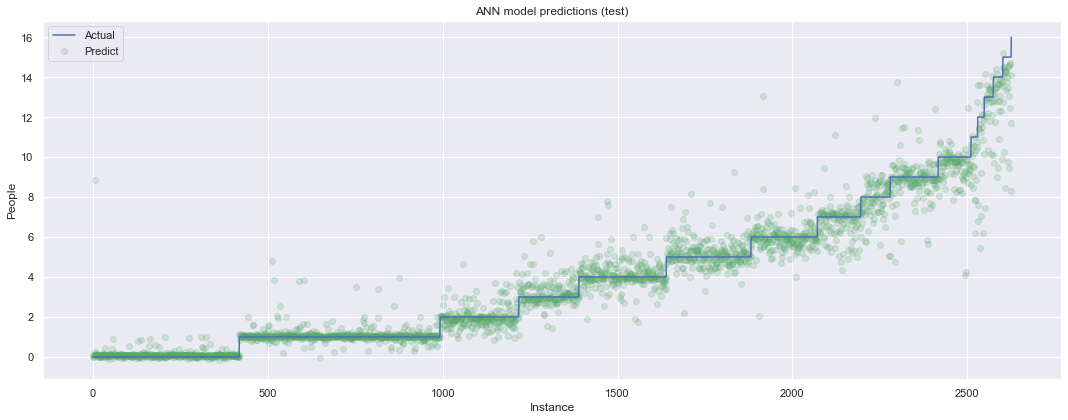

Saving figure ANN_pred_actual_reduced_train


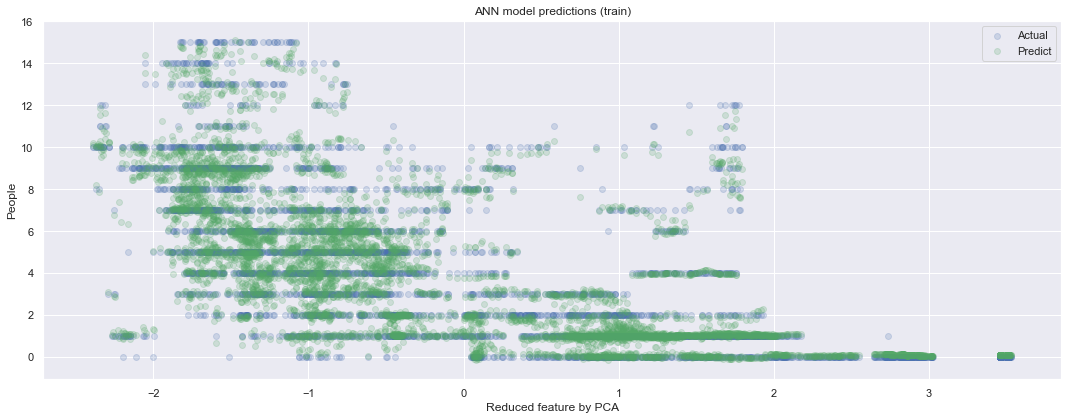

Saving figure ANN_pred_actual_reduced_test


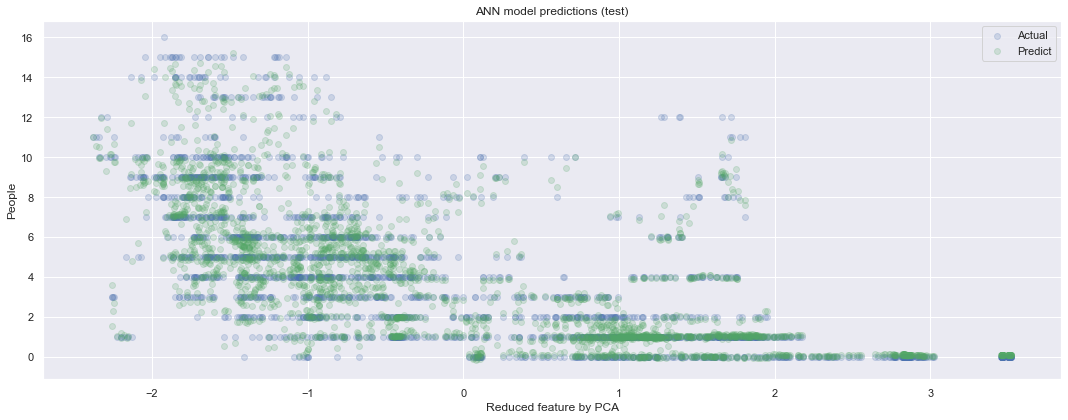

In [14]:
pca = PCA(n_components=1)
pca.fit(X_avg_train_val_scaled)

utils.plot_prediction_wtih_pca(model, pca, X_avg_train_val_scaled, X_avg_test_scaled, y_avg_train_val, y_avg_test, name='ANN')